In [1]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable

/home/nutapolt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = ''
        self.path = path
        print(path)
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        # self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    
        
        print("Done.")
        return self.raw
    def filter(self, freq):
        raw = self.raw
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        return  raw
    def raw_ica(self):
        raw = self.raw
        ica = mne.preprocessing.ICA(n_components=1, max_iter=100)
        ica.fit(raw)
        ica.exclude = [1, 2]  # details on how we picked these are omitted here
        ica.plot_properties(raw, picks=ica.exclude)
        ica.apply(raw)
        print('ICA DONE ????')
        return  raw
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = 0
        tmax = 4
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    
        
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        #print(f">>> Extract all subjects from: {fullpath}.")
        extension = "fif"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                #print(path_file)
                #print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)
        eegbci.standardize(raw)
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        print("Done.")
        return events , event_id
# getepoch(raw,4, 10,reject_bad=False,on_missing='warn')    
    def get_X_y(self):
        events = mne.find_events(raw)
        
        epochs = mne.Epochs(
        raw,
        events,
        event_id=[1,2,3],
        tmin=-4,
        tmax=10,
        picks="data",
        on_missing='warn',
        baseline=None,
        preload=True
    )
        plt.figure(figsize=(7, 3))
        n_samples_to_plot = int(0.5 * epochs.info['sfreq'])  # plot 0.5 seconds of data
        plt.plot(epochs.times[:n_samples_to_plot],
         epochs.get_data()[0, 0, :n_samples_to_plot], color='black')
            #events , event_id=self.create_epochs()
        self.X = epochs.get_data()
        self.y = epochs.events[:, -1]
        return self.X, self.y

        
def getepoch(raws,trial_duration, calibration_duration,reject_bad=False,on_missing='warn'):
    #reject_criteria = dict(eeg=100e-6)  # 100 µV
    #flat_criteria = dict(eeg=1e-6)  # 1 µV
    epochs_list = []
    raws = [raws]
    print(len(raws))
    for raw in raws:
        print(raw)
        events = mne.find_events(raw)
        epochs = mne.Epochs(
            raw,
            events,
            event_id=[1,2,3],
            tmin=-calibration_duration,
            tmax=trial_duration,
            picks="data",
            on_missing=on_missing,
            baseline=None
        )
        
        epochs_list.append(epochs)
    epochs = mne.concatenate_epochs(epochs_list)
    labels = epochs.events[:,-1]
    
    print(f'Found {len(labels)} epochs')
    print(epochs)
    print(labels)

    return epochs.get_data(),epochs,labels

        
        
def do_plot(train_loss, valid_loss,ty):
    if ty == "loss":
        plt.figure(figsize=(10,10))
        
        plt.plot(train_loss, label='train_loss')
        plt.plot(valid_loss, label='valid_loss')
        plt.title('loss {}'.format(iter))
        plt.legend()
        plt.show()
    if ty == "acc":
        plt.figure(figsize=(10,10))
        
        plot_ty=torch.tensor(train_loss, device = 'cpu')
        plat_va=torch.tensor(valid_loss, device = 'cpu')
        plt.plot(plot_ty, label='train_acc')
        plt.plot(plat_va, label='valid_acc')
        plt.title('acc {}'.format(iter))
        plt.legend()
        plt.show()

In [17]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [3, 5, 7]
subjects = [i for i in range(2,3)]
#subjects = [1]
# runs = [6,10,14]
print(path)
eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter
freq = (1., 45.)
raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()
#eeg.create_epochs()

/tmp/ipykernel_2749/506747615.py:71: RuntimeWarning: This filename (S002/S002R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/tmp/ipykernel_2749/506747615.py:71: RuntimeWarning: This filename (S002/S002R05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/tmp/ipykernel_2749/506747615.py:71: RuntimeWarning: This filename (S002/S002R07.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fi

Raw done
>>> Apply filter.
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Filter done


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


144 events found
Event IDs: [1 2 4]
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 3501 original time points ...
6 bad epochs dropped


/tmp/ipykernel_2749/506747615.py:92: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


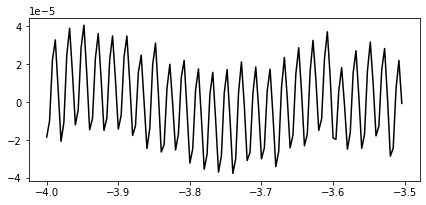

In [18]:
X, y = eeg.get_X_y()

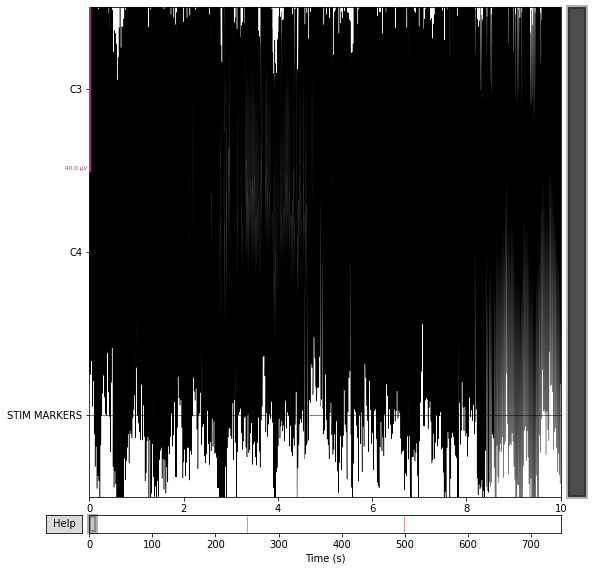

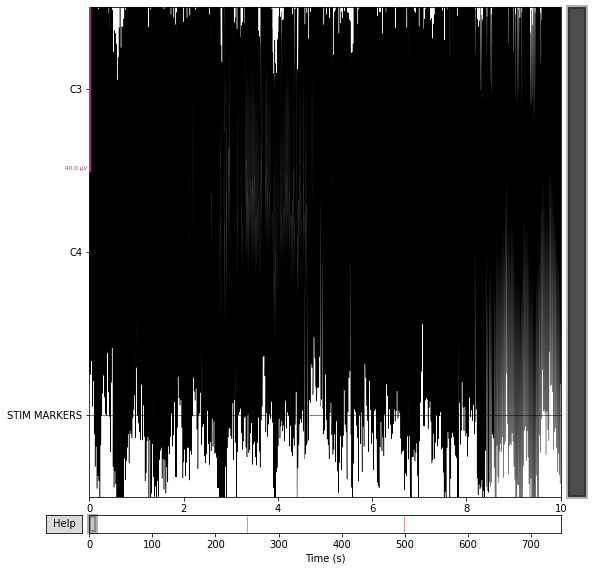

In [23]:
raw.plot()

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


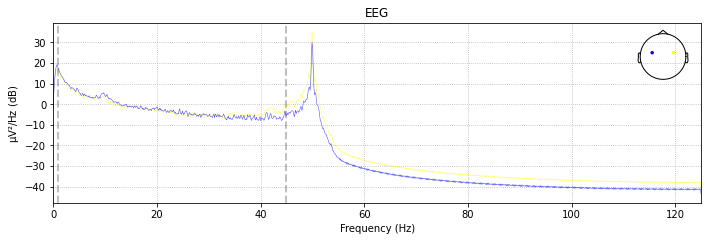

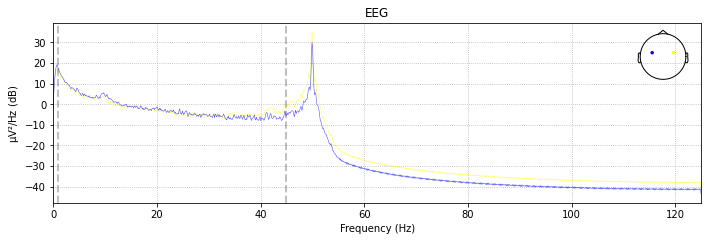

In [30]:
raw.plot_psd()

In [48]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = ''
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        # self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    
        
        print("Done.")
        return self.raw
    def filter(self, freq):
        raw = self.raw
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        return  raw
    def raw_ica(self):
        raw = self.raw
        ica = mne.preprocessing.ICA(n_components=64, max_iter=100)
        ica.fit(raw)
        ica.exclude = [1, 2]  # details on how we picked these are omitted here
        ica.plot_properties(raw, picks=ica.exclude)
        ica.apply(raw)
        print('ICA DONE ????')
        return  raw
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = 0
        tmax = 4
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        
        plt.figure(figsize=(7, 3))
        n_samples_to_plot = int(0.5 * self.epochs.info['sfreq'])  # plot 0.5 seconds of data
        plt.plot(self.epochs.times[:n_samples_to_plot],
         self.epochs.get_data()[0, 0, :n_samples_to_plot], color='black')
        return events , event_id
        
        print("Done.")
    
    def get_X_y(self):
        if self.epochs is None:
            events , event_id=self.create_epochs()
        
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        
        
        return self.X, self.y
    
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        #print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                #print(path_file)
                #print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)
        eegbci.standardize(raw)
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        
        
        
def do_plot(train_loss, valid_loss,ty):
    if ty == "loss":
        plt.figure(figsize=(10,10))
        
        plt.plot(train_loss, label='train_loss')
        plt.plot(valid_loss, label='valid_loss')
        plt.title('loss {}'.format(iter))
        plt.legend()
        plt.show()
    if ty == "acc":
        plt.figure(figsize=(10,10))
        
        plot_ty=torch.tensor(train_loss, device = 'cpu')
        plat_va=torch.tensor(valid_loss, device = 'cpu')
        plt.plot(plot_ty, label='train_acc')
        plt.plot(plat_va, label='valid_acc')
        plt.title('acc {}'.format(iter))
        plt.legend()
        plt.show()

Raw done
>>> Apply filter.
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 sec)

Filter done
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


(array([[  672,     0,     1],
        [ 2000,     0,     0],
        [ 3328,     0,     0],
        [ 4656,     0,     1],
        [ 5984,     0,     1],
        [ 7312,     0,     0],
        [ 8640,     0,     1],
        [ 9968,     0,     0],
        [11296,     0,     1],
        [12624,     0,     0],
        [13952,     0,     0],
        [15280,     0,     1],
        [16608,     0,     0],
        [17936,     0,     1],
        [19264,     0,     0],
        [20672,     0,     0],
        [22000,     0,     1],
        [23328,     0,     0],
        [24656,     0,     1],
        [25984,     0,     0],
        [27312,     0,     1],
        [28640,     0,     0],
        [29968,     0,     1],
        [31296,     0,     1],
        [32624,     0,     0],
        [33952,     0,     0],
        [35280,     0,     1],
        [36608,     0,     1],
        [37936,     0,     0],
        [39264,     0,     0],
        [40672,     0,     1],
        [42000,     0,     0],
        

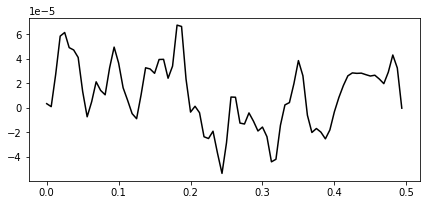

In [49]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = 'physionet.org/files/eegmmidb/1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [4, 8, 12]
subjects = [i for i in range(1,2)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print("Raw done")
# apply filter
freq = (1., 40.)
raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()
eeg.create_epochs()